In [1]:
from collections import defaultdict
from wmdecompose.documents import Document
from wmdecompose.gale_shapeley import Matcher
from wmdecompose.models import LC_RWMD, WMD, WMDPairs
from wmdecompose.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer

from random import shuffle,choices
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

from redditcleaner import clean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import umap
import spacy
import pickle

%load_ext autoreload
%autoreload 2

## 1. Prepare reddit data

### 1.1 Load data and stopwords; filter data for paper analysis.

In [3]:
%%time

# import spacy stopwords

from spacy.lang.en.stop_words import STOP_WORDS
stopword_list=STOP_WORDS

# read reddit data

PATH = "../data/"
reddit_data = pd.read_json(f"{PATH}self_posts_conservative_and_conspiracy_subs.json",lines=True)

CPU times: user 19.9 s, sys: 23.6 s, total: 43.6 s
Wall time: 50.9 s


In [4]:
# filter out other subs

reddit_data = reddit_data[reddit_data.subreddit.isin(["conspiracy","The_Donald"])]

In [5]:
# add field for number of words

reddit_data["length"] = reddit_data["selftext"].apply(lambda x: len(x.split()))

# filter to at least 30 words

reddit_data = reddit_data[reddit_data.length>=30].reset_index(drop=True)

In [6]:
# add dummies indicating time period (t0 or t1) - see paper for definitions

reddit_data["t0"] = [1 if (i < 1468209600) & (i>=1436598580) else 0 for i in reddit_data["created_utc"]]
reddit_data["t1"] = [1 if i > 1535688000 else 0 for i in reddit_data["created_utc"]]

# filter

reddit_data = reddit_data[(reddit_data.t0==1)|(reddit_data.t1==1)]
print(reddit_data.groupby("subreddit").t0.value_counts())

subreddit   t0
The_Donald  1     29855
            0     12560
conspiracy  0     13045
            1      6075
Name: t0, dtype: int64


In [7]:
# sample

s_size = 5000
rs = 42

sample = reddit_data.groupby(["subreddit", "t0"]).apply(lambda x: x.sample(s_size, random_state=rs)).reset_index(drop=True)
print(sample.groupby("subreddit").t0.value_counts())

del reddit_data

subreddit   t0
The_Donald  0     5000
            1     5000
conspiracy  0     5000
            1     5000
Name: t0, dtype: int64


### 1.2 Remove special formatting and stopwords

In [8]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [9]:
%%time 

# combine title and body

sample["full_text"] = sample["title"] + ". " + sample["selftext"]

# remove URLs

URL_REGEX = r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
sample['full_text'] =  sample['full_text'].apply(lambda x: re.sub(URL_REGEX,'', str(x)))

# apply redditcleaner function

sample['full_text'] = sample['full_text'].map(clean)

# lowercase 

sample["full_text"] = sample["full_text"].str.lower()

CPU times: user 5.21 s, sys: 59.4 ms, total: 5.27 s
Wall time: 5.3 s


Lemmatize and remove stopwords with spaCy

In [10]:
%%time

nlp = spacy.load("en_core_web_sm")

posts = list(sample["full_text"])

lemmatized_list = []

for doc in nlp.pipe(posts, batch_size=32, n_process=3, disable=["parser", "ner"]):

    lemmas = [token.lemma_.lower() for token in doc]
    lemmas_no_stopwords = [lemma for lemma in lemmas if not lemma in stopword_list]
    lemmatized = " ".join(lemmas_no_stopwords)
    lemmatized_list.append(lemmatized)
    
sample["full_text_clean"] = lemmatized_list


CPU times: user 44.1 s, sys: 4.15 s, total: 48.2 s
Wall time: 2min 6s


In [11]:
print(sample["full_text"][2])
print()
print(sample["full_text_clean"][2])

how'd we miss this little gem?. i know hollywood hates conservatives but look at this trash from 2005:  i've not seen the movie but apparently a group of libtards invites scary conservatives to dinner and murder them. and this was pre-antifa. can you imagine the outrage if the roles were reversed? unfuckingbelieveable!

miss little gem ? . know hollywood hate conservative look trash 2005 :   movie apparently group libtard invite scary conservative dinner murder . pre - antifa . imagine outrage role reverse ? unfuckingbelieveable !


Denoise, remove special characters.

In [12]:
%%time

sample['full_text_clean']=sample['full_text_clean'].apply(denoise_text)
sample['full_text_clean']=sample['full_text_clean'].apply(remove_special_characters)
sample['full_text_clean']=sample['full_text_clean'].str.replace("ampamp","")

CPU times: user 1.57 s, sys: 143 ms, total: 1.71 s
Wall time: 1.72 s


Remove stopwords again, after other preprocessing.

In [13]:
%%time 

sample['full_text_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['full_text_clean']]

CPU times: user 3.86 s, sys: 18 ms, total: 3.88 s
Wall time: 3.89 s


In [14]:
print(sample["full_text"][2])
print()
print(sample["full_text_clean"][2])

how'd we miss this little gem?. i know hollywood hates conservatives but look at this trash from 2005:  i've not seen the movie but apparently a group of libtards invites scary conservatives to dinner and murder them. and this was pre-antifa. can you imagine the outrage if the roles were reversed? unfuckingbelieveable!

miss little gem know hollywood hate conservative look trash movie apparently group libtard invite scary conservative dinner murder pre antifa imagine outrage role reverse unfuckingbelieveable


Find phrases.

In [15]:
PHRASING = True
MIN = 100
THRESHOLD = 500

In [16]:
%%time

if PHRASING:
    sample['full_text_clean']= get_phrases([tokenizer.tokenize(i) for i in sample['full_text_clean']],
                                        min_count = MIN, 
                                        threshold = THRESHOLD)

Initializing bigram Phrases.
Initializing trigram Phrases.
Finding bigrams in data.
Finding trigrams in data.
CPU times: user 27.5 s, sys: 431 ms, total: 27.9 s
Wall time: 28.1 s


In [17]:
sample["full_text_clean"] = [" ".join(post) for post in sample["full_text_clean"]]

Data _before_ preprocessing and phrasing.

In [18]:
sample['full_text'][0]

'next time you hear a lib pull the "muh popular vote" card, ask them these 5 questions and watch as their npc software crashes, saying "error: rebuttal not found. divert, insult, or play race card. contact it dept if problem persists").  question answer  - -   which group of states did trump primarily focus much of his campaign resources/time on? the rust belt (wisconsin, michigan, ohio, pennsylvania, and indiana)   which 2 states with a combined population of 60m(i.e. 20% of the entire us) did trump almost completely ignore? california &amp;amp; new york.   why did trump not even try to woo over 60m people? because he knows the electoral system, and there was no incentive to campaign in states you are guaranteed to lose   if there were no ec in 2016, and only the popular vote mattered, what would have changed? everything would be different. trump\'s entire campaign strategy would have changed by investing huge amounts of resources/time into ca &amp;amp; ny  also question 5: why did op

Data _after_ preprocessing and phrasing.

In [19]:
sample['full_text_clean'][0]

'time hear lib pull muh popular_vote card ask_question watch npc software crash error rebuttal find divert insult play race card contact dept problem persist question_answer group state trump primarily focus campaign resource time rust_belt wisconsin_michigan ohio pennsylvania indiana state combined population mie entire trump completely_ignore california new_york trump try woo m people know electoral system incentive campaign state guarantee lose ec popular_vote matter change different trump entire campaign strategy change invest huge resource time ny question op lie question_answer half retarded time sowie'

### 1.3 Separate r/conservative and r/The_Donald posts

In [20]:
con = sample[sample.subreddit == "conspiracy"].sort_values(by="created_utc").reset_index(drop=True)
td = sample[sample.subreddit == "The_Donald"].sort_values(by="created_utc").reset_index(drop=True)

In [21]:
con = con.full_text_clean.tolist()
td = td.full_text_clean.tolist()

## 2. WMD

### 2.1 Tokenize data, remove infrequent terms

In [22]:
con_tok = list(map(lambda x: tokenize(x, tokenizer), con))
td_tok = list(map(lambda x: tokenize(x, tokenizer), td))

In [23]:
# REMOVE WORDS OCCURRINIG <20 times

# 1. get list of word counts

all_tok = con_tok + td_tok
all_tok_flat = [item for sublist in all_tok for item in sublist]
print(len(all_tok_flat))
all_tok_flat = pd.Series(all_tok_flat)
word_counts = all_tok_flat.value_counts()

# 2. remove words occurring less than 20 times

thresh = 20

words_to_keep = list(word_counts[word_counts>=thresh].index)

# 3. filter out words

con_tok = [list(filter(lambda word: word in words_to_keep, l)) for l in con_tok]
td_tok = [list(filter(lambda word: word in words_to_keep, l)) for l in td_tok]

print(len([item for sublist in con_tok+td_tok for item in sublist]))



1841640
1621375


In [24]:
con_sample = [" ".join(doc) for doc in con_tok]
td_sample = [" ".join(doc) for doc in td_tok]

In [25]:
print(len(con_sample))
print(len(td_sample))

10000
10000


### 2.2 Load pretrained Google News W2V model

In [26]:
finetuned = True

In [27]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('/Users/jack/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using Reddit data.")
    %time model = KeyedVectors.load_word2vec_format('../../embeddings/reddit_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using Reddit data.
CPU times: user 44.3 s, sys: 529 ms, total: 44.9 s
Wall time: 45 s


In [28]:
model.distance("trump", "conservative")

0.5155870914459229

In [29]:
model.distance("trump","progressive")

0.6331793665885925

In [30]:
model.distance("centipede","maga")

0.26222318410873413

In [31]:
model.distance("conspiracy","theory")

0.3817483186721802

### 2.3 Load corpus and remove OOV words

In [32]:
%%time

corpus = con_sample + td_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 3.49 s, sys: 68.2 ms, total: 3.55 s
Wall time: 3.58 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l1', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tfidf_tokenize at 0x1a1b2465f0>,
                use_idf=False, vocabulary=None)

In [33]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 9.35 ms, sys: 95 µs, total: 9.44 ms
Wall time: 9.49 ms


In [34]:
len(oov)

407

In [36]:
%time con_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), con_sample))
%time td_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), td_sample))

CPU times: user 5.8 s, sys: 34 ms, total: 5.83 s
Wall time: 5.86 s
CPU times: user 3.64 s, sys: 16.2 ms, total: 3.66 s
Wall time: 3.67 s


In [38]:
corpus = con_sample + td_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 51 µs, sys: 1e+03 ns, total: 52 µs
Wall time: 57.2 µs
CPU times: user 3.23 s, sys: 61.8 ms, total: 3.29 s
Wall time: 3.33 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l1', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tfidf_tokenize at 0x1a1b2465f0>,
                use_idf=True, vocabulary=None)

Bag-of-words vectorizer.

In [39]:
%time
con_nbow = vectorizer.transform(con_sample)
td_nbow = vectorizer.transform(td_sample)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


In [40]:
con_tok = list(map(lambda x: tokenize(x, tokenizer), con_sample))
td_tok =list(map(lambda x: tokenize(x, tokenizer), td_sample))

In [42]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 12.7 ms, sys: 233 µs, total: 12.9 ms
Wall time: 13.1 ms


In [43]:
len(oov_)

0

Remove empty docs, and make sure both samples are same size

In [44]:
con_tok = list(map(lambda x: tokenize(x, tokenizer), con_sample))
td_tok = list(map(lambda x: tokenize(x, tokenizer), td_sample))

con_tok_empty = [c for c,i in enumerate(con_tok) if len(i)==0]
td_tok_empty = [c for c,i in enumerate(td_tok) if len(i)==0]

print(con_tok_empty)
print(td_tok_empty)

[]
[3675, 3825, 4121]


In [45]:
# remove empty docs

for i in sorted(td_tok_empty,reverse=True):
    del td_tok[i],td_sample[i], con_tok[i],con_sample[i]
    


In [46]:
print(len(con_tok),len(td_tok))

con_nbow = vectorizer.transform(con_sample)
td_nbow = vectorizer.transform(td_sample)

9997 9997


### 2.4 Get features and embeddings

In [47]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [48]:
E = model[features]


### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [49]:
X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [50]:
%%time

K = range(10,110, 10)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


Assign labels and centroids to separate variables for later use.

#### 2.5.2 T-SNE + Kmeans

In [51]:
method='barnes_hut'
n_components = 2
verbose = 1

In [52]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9349 samples in 0.174s...
[t-SNE] Computed neighbors for 9349 samples in 47.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9349
[t-SNE] Computed conditional probabilities for sample 2000 / 9349
[t-SNE] Computed conditional probabilities for sample 3000 / 9349
[t-SNE] Computed conditional probabilities for sample 4000 / 9349
[t-SNE] Computed conditional probabilities for sample 5000 / 9349
[t-SNE] Computed conditional probabilities for sample 6000 / 9349
[t-SNE] Computed conditional probabilities for sample 7000 / 9349
[t-SNE] Computed conditional probabilities for sample 8000 / 9349
[t-SNE] Computed conditional probabilities for sample 9000 / 9349
[t-SNE] Computed conditional probabilities for sample 9349 / 9349
[t-SNE] Mean sigma: 0.682172
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.140457
[t-SNE] KL divergence after 1000 iterations: 2.821657


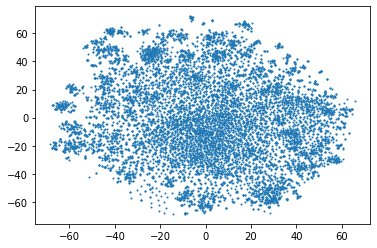

In [53]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

In [54]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 10 The average silhouette_score is : 0.35294896
For n_clusters = 20 The average silhouette_score is : 0.37262264
For n_clusters = 30 The average silhouette_score is : 0.3682027
For n_clusters = 40 The average silhouette_score is : 0.3631177
For n_clusters = 50 The average silhouette_score is : 0.36479822
For n_clusters = 60 The average silhouette_score is : 0.36408612
For n_clusters = 70 The average silhouette_score is : 0.3670734
For n_clusters = 80 The average silhouette_score is : 0.37234008
For n_clusters = 90 The average silhouette_score is : 0.365822
For n_clusters = 100 The average silhouette_score is : 0.3647054
CPU times: user 60 s, sys: 5.03 s, total: 1min 4s
Wall time: 37 s


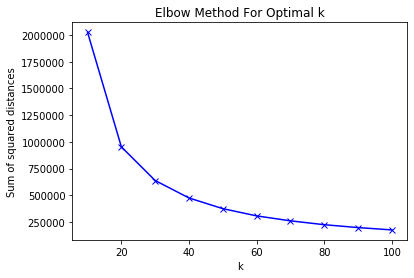

In [55]:
plot_kmeans(K,tsne_ssd,"elbow")

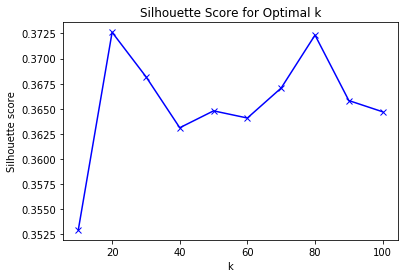

In [56]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [57]:
k = 100

In [58]:
%%time

km_tsne = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_tsne)
labels = km_tsne.labels_

CPU times: user 1.94 s, sys: 276 ms, total: 2.22 s
Wall time: 2.22 s


Create an index that maps each word to a cluster.

In [59]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

Now, conversely, create an index that maps each cluster to a word.

In [60]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indices of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [62]:
import random
random.seed(42)

In [63]:
%%time 

con_docs, td_docs = [], []

for idx, doc in enumerate(con_tok):
    con_docs.append(Document(doc, con_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(td_tok):
    td_docs.append(Document(doc, td_nbow[idx], word2idx, E))

CPU times: user 4.44 s, sys: 1.42 s, total: 5.86 s
Wall time: 5.95 s


### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all conspiracy and all TD posts. This is performed for the t0 corpus and for the t1 corpus.

In [64]:
# initialize LCRWMD

lc_rwmd_t0 = LC_RWMD(con_docs[:4997], td_docs[:4997],con_nbow[:4997],td_nbow[:4997],E)
lc_rwmd_t1 = LC_RWMD(con_docs[4997:], td_docs[4997:],con_nbow[4997:],td_nbow[4997:],E)

In [ ]:
# get cosine distances

%time lc_rwmd_t0.get_D('cosine')
%time lc_rwmd_t1.get_D('cosine')

In [ ]:
# write pickle to easily switch between cosine and euclidean if desired

# pickle.dump(lc_rwmd_t0,open("../checkpoints/lc_rwmd_t0_cosine.p","wb"))
# pickle.dump(lc_rwmd_t1,open("../checkpoints/lc_rwmd_t1_cosine.p","wb"))

In [65]:
# # read pickle

# lc_rwmd_t0 = pickle.load(open("../checkpoints/lc_rwmd_t0_cosine.p","rb"))
# lc_rwmd_t1 = pickle.load(open("../checkpoints/lc_rwmd_t1_cosine.p","rb"))

In [66]:
print(f"Mean of all 25M pairwise LCRWMD distances at t0: {np.concatenate(lc_rwmd_t0.D).mean()}")
print(f"Mean of all 25M pairwise LCRWMD distances at t1: {np.concatenate(lc_rwmd_t1.D).mean()}")

Mean of all 25M pairwise LCRWMD distances at t0: 0.4894437693191202
Mean of all 25M pairwise LCRWMD distances at t1: 0.4857844525163851


In [67]:
# RANDOM PAIRING TRIAL

from scipy.stats import ttest_ind


t0_distros = []
t1_distros = []
t_statistics = []
p_values = []

n = 10

for i in range(n):
    
    print(i)

    # generate random pairs

    con_idx0, td_idx0 = [list(range(0,4997)) for r in range(2)] 
    con_idx1, td_idx1 = [list(range(0,5000)) for r in range(2)] 
    
    for idx in [con_idx0, td_idx0, con_idx1, td_idx1]:
        shuffle(idx)
    

    pairs0 = list(zip(con_idx0, td_idx0))
    pairs1 = list(zip(con_idx1, td_idx1))
    
    # get distannces of random pairs
    
    print("Getting distances of random pairs...")

    wmd_pairs_t0 = WMDPairs(con_docs[:4997],td_docs[:4997],pairs0,E,idx2word,metric="cosine")
    wmd_pairs_t0.get_distances(decompose = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True,
                             relax = False)

    wmd_pairs_t1 = WMDPairs(con_docs[4997:],td_docs[4997:],pairs1,E,idx2word,metric="cosine")
    wmd_pairs_t1.get_distances(decompose = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True,
                             relax = False)

    # create 1D array

    distances_t0 = np.concatenate(wmd_pairs_t0.distances)
    distances_t1 = np.concatenate(wmd_pairs_t1.distances)

    # remove zeros

    distances_t0 = distances_t0[distances_t0!=0]
    distances_t1 = distances_t1[distances_t1!=0]

    # t test

    ttest = ttest_ind(distances_t0,distances_t1)
    t_stat, p_val = ttest[0],ttest[1]

    # save values

    t0_distros.append(distances_t0)
    t1_distros.append(distances_t1)
    t_statistics.append(t_stat)
    p_values.append(p_val)
        
    
# print(t0_means) 
# print(t1_means) 
# print(t_statistics)   
# print(p_values)  

0
Getting distances of random pairs...
Calculated distances between approximately 0 documents.
Calculated distances between approximately 1000 documents.
Calculated distances between approximately 2000 documents.
Calculated distances between approximately 3000 documents.
Calculated distances between approximately 4000 documents.
Calculated distances between approximately 0 documents.
Calculated distances between approximately 1000 documents.
Calculated distances between approximately 2000 documents.
Calculated distances between approximately 3000 documents.
Calculated distances between approximately 4000 documents.
1
Getting distances of random pairs...
Calculated distances between approximately 0 documents.
Calculated distances between approximately 1000 documents.
Calculated distances between approximately 2000 documents.
Calculated distances between approximately 3000 documents.
Calculated distances between approximately 4000 documents.
Calculated distances between approximately 0 d

In [68]:
np.concatenate(t0_distros).mean()

0.5482151865840703

In [69]:
np.concatenate(t1_distros).mean()

0.5445319190360477

In [73]:
ttest_ind(np.concatenate(t0_distros),np.concatenate(t1_distros))

Ttest_indResult(statistic=13.709971583424506, pvalue=9.674684609452017e-43)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


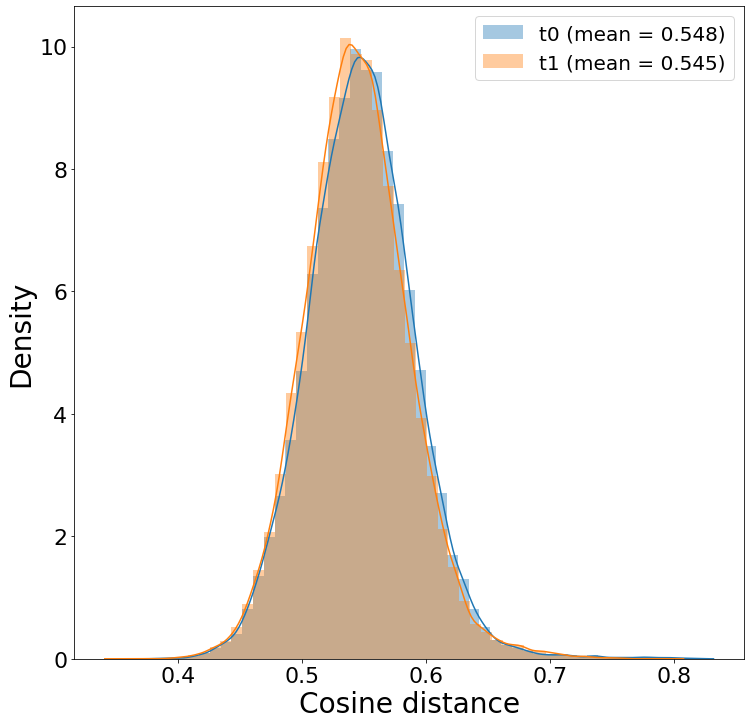

In [125]:
plt.figure(figsize=(12,12))


sns.distplot(x = np.concatenate(t0_distros),hist=True,norm_hist=True,label="t0 (mean = 0.548)")
sns.distplot(x = np.concatenate(t1_distros),hist=True,norm_hist=True,label = "t1 (mean = 0.545)")

plt.ylabel("Density",fontsize=28)
plt.xlabel("Cosine distance",fontsize=28)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(prop={'size': 20})

plt.savefig("/Users/jack/wmdecompose/paper/images/wmd_random.png",bbox_inches="tight",dpi=500)

plt.show()

### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [74]:
%%time 

con_docs, td_docs = [], []

for idx, doc in enumerate(con_tok):
    con_docs.append(Document(doc, con_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(td_tok):
    td_docs.append(Document(doc, td_nbow[idx], word2idx, E))

CPU times: user 5.15 s, sys: 2.28 s, total: 7.44 s
Wall time: 7.86 s


In [75]:
# Options: 'gale_shapeley','random','full'

pairing = 'gale_shapeley'

In [76]:
%%time

if pairing == 'gale_shapeley':
    
    print("Running Gale-Shapeley pairing.")
    
    # Run G-S pairing for the t0 docs and the t1 docs separately 
    
    matcher_t0 = Matcher(lc_rwmd_t0.D)
    engaged_t0 = matcher_t0.matchmaker()
    matcher_t0.check()
    pairs_t0 = [(k, v) for k, v in engaged_t0.items()]
    
    matcher_t1 = Matcher(lc_rwmd_t1.D)
    engaged_t1 = matcher_t1.matchmaker()
    matcher_t1.check()
    pairs_t1 = [(k, v) for k, v in engaged_t1.items()]
    


Running Gale-Shapeley pairing.
CPU times: user 8min 57s, sys: 40.2 s, total: 9min 37s
Wall time: 10min 3s


In [77]:
%%time 

wmd_pairs_flow0 = WMDPairs(con_docs[:4997],td_docs[:4997],pairs_t0,E,idx2word,metric="cosine")
wmd_pairs_flow0.get_distances(decompose = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True,
                             relax = False)

wmd_pairs_flow1 = WMDPairs(con_docs[4997:],td_docs[4997:],pairs_t1,E,idx2word,metric="cosine")
wmd_pairs_flow1.get_distances(decompose = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True,
                             relax = False)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 1000 documents.
Calculated distances between approximately 2000 documents.
Calculated distances between approximately 3000 documents.
Calculated distances between approximately 4000 documents.
Calculated distances between approximately 0 documents.
Calculated distances between approximately 1000 documents.
Calculated distances between approximately 2000 documents.
Calculated distances between approximately 3000 documents.
Calculated distances between approximately 4000 documents.
CPU times: user 1h 25s, sys: 24min, total: 1h 24min 25s
Wall time: 53min 43s


In [78]:
wmd_pairs_flow0.distances[wmd_pairs_flow0.distances!=0].mean()

0.47800860653935634

In [79]:
wmd_pairs_flow1.distances[wmd_pairs_flow1.distances!=0].mean()

0.4688645437773294

In [128]:
ttest_ind(wmd_pairs_flow0.distances[wmd_pairs_flow0.distances!=0],wmd_pairs_flow1.distances[wmd_pairs_flow1.distances!=0])

Ttest_indResult(statistic=8.050509143195779, pvalue=9.183908853705265e-16)

In [80]:
wmd_pairs_flow0.get_differences()
wmd_pairs_flow1.get_differences()


### 3.1 Intepreting pairwise WMD flows

In [135]:
# words most distinguishing r/conspiracy from r/TD, t0

{k: v for k, v in sorted(wmd_pairs_flow0.wd_source_diff.items(), key=lambda item: item[1], reverse=True)}

{'conspiracy': 8.785420000000014,
 'government': 6.670019999999999,
 'world': 3.8951700000000034,
 'israel': 3.7194299999999987,
 'find': 3.663520000000002,
 'video': 3.5569800000000003,
 'information': 3.0770299999999997,
 'documentary': 3.000870000000001,
 'theory': 2.967289999999998,
 'isis': 2.9660700000000007,
 'control': 2.938550000000005,
 'cia': 2.9312500000000012,
 'use': 2.9246499999999984,
 'story': 2.814080000000005,
 'evidence': 2.7656,
 'link': 2.695459999999999,
 'conspiracy_theory': 2.6158599999999996,
 'war': 2.582060000000001,
 'r_conspiracy': 2.367500000000001,
 'report': 2.360950000000003,
 'truth': 2.3569799999999974,
 'research': 2.3187100000000003,
 'article': 2.3078000000000025,
 'false_flag': 2.29617,
 'event': 2.210580000000001,
 'power': 2.196220000000001,
 'shooting': 2.1492400000000003,
 'vaccine': 2.1271999999999998,
 'company': 2.1245200000000017,
 'page': 2.034209999999997,
 'military': 2.023529999999999,
 'create': 1.9889400000000006,
 'police': 1.91769

In [136]:
# words most distinguishing r/conspiracy from r/TD, t1

{k: v for k, v in sorted(wmd_pairs_flow1.wd_source_diff.items(), key=lambda item: item[1], reverse=True)}

{'conspiracy': 11.17193000000002,
 'epstein': 8.97276,
 'video': 5.298800000000007,
 'control': 4.973939999999999,
 'vaccine': 4.462080000000003,
 'theory': 3.9370600000000016,
 'world': 3.6941300000000026,
 'find': 3.4578700000000033,
 'government': 3.3316500000000087,
 'cia': 2.885840000000001,
 'conspiracy_theory': 2.809170000000001,
 'information': 2.8026100000000005,
 'alien': 2.7830599999999985,
 'israel': 2.714099999999999,
 'link': 2.6244699999999925,
 'suicide': 2.620949999999999,
 'documentary': 2.50205,
 'kill': 2.473929999999999,
 'research': 2.3891899999999993,
 'believe': 2.3459800000000057,
 'use': 2.3355200000000007,
 'human': 2.287290000000004,
 'post': 2.264019999999999,
 'elite': 2.228530000000002,
 'ss': 2.1843999999999992,
 'create': 2.16983,
 'death': 2.1646199999999975,
 'info': 2.143769999999999,
 'jeffrey_epstein': 2.1406799999999993,
 'thought': 2.057050000000003,
 'topic': 2.0284,
 'study': 2.00375,
 'q': 1.9559899999999995,
 'happen': 1.9294400000000067,
 's

In [137]:
# words most distinguishing r/TD from r/conspiracy, t0

{k: v for k, v in sorted(wmd_pairs_flow0.wd_sink_diff.items(), key=lambda item: item[1], reverse=True)}

{'trump': 45.85296000000001,
 'vote': 14.963350000000005,
 'bernie': 10.787280000000003,
 'hillary': 10.491449999999997,
 'cruz': 10.009480000000002,
 'win': 9.583180000000004,
 'donald': 9.57943,
 'donald_trump': 8.812000000000006,
 'delegate': 7.948620000000001,
 'cuck': 7.497219999999999,
 'maga': 7.350429999999992,
 'support': 7.269969999999997,
 'high_energy': 6.615539999999995,
 'centipede': 6.318490000000002,
 'candidate': 5.993000000000003,
 'america_great': 5.803979999999999,
 'rally': 5.63422,
 'liberal': 5.61893,
 'kasich': 5.354209999999999,
 'campaign': 5.259389999999998,
 'trump_supporter': 5.072659999999996,
 'need': 5.027420000000002,
 'poll': 4.720519999999999,
 'fuck': 4.679089999999999,
 'sander': 4.4834200000000015,
 'racist': 4.17912,
 'want': 4.0561000000000025,
 'muslim': 4.022899999999999,
 'primary': 3.83853,
 'let': 3.7719399999999994,
 'debate': 3.7511499999999973,
 'supporter': 3.673679999999999,
 'love': 3.645170000000001,
 'great': 3.6253199999999985,
 'am

In [139]:
# words most distinguishing r/TD from r/conspiracy, t1

{k: v for k, v in sorted(wmd_pairs_flow1.wd_sink_diff.items(), key=lambda item: item[1], reverse=True)}

{'trump': 12.828659999999998,
 '___': 11.704689999999996,
 'vote': 10.696039999999991,
 'democrat': 6.50112,
 'president': 6.447510000000003,
 'dem': 5.896949999999998,
 'left': 5.115390000000001,
 'pes': 4.758570000000002,
 'election': 4.735320000000004,
 'liberal': 4.6990300000000005,
 'win': 4.329440000000001,
 'republican': 4.270839999999998,
 'conservative': 4.257629999999998,
 'democrats': 4.063789999999999,
 'maga': 3.8770100000000016,
 'american': 3.8436199999999987,
 'leftist': 3.74703,
 'country': 3.5624999999999973,
 'obama': 3.4555700000000003,
 'support': 3.4011400000000007,
 'america': 3.3566200000000004,
 'woman': 3.2871199999999985,
 'man': 3.198789999999996,
 'mueller': 3.123050000000001,
 'daily_bible_scripture': 3.1192700000000015,
 'thank': 3.1071200000000028,
 'quarantine': 3.048079999999999,
 'let': 2.9723900000000008,
 'racist': 2.9601300000000013,
 'kavanaugh': 2.955509999999999,
 'right': 2.8857900000000023,
 'geotus': 2.8614599999999997,
 'significant_tweet': 

In [84]:
# words most distinguishing r/TD from r/conspiracy, t1

{k: v for k, v in sorted(wmd_pairs_flow1.wd_sink_diff.items(), key=lambda item: item[1], reverse=True)})

['trump',
 '___',
 'vote',
 'democrat',
 'president',
 'dem',
 'left',
 'pes',
 'election',
 'liberal',
 'win']

## Combine into DF

In [85]:
top_words_t0 = {k: v for k, v in sorted(wmd_pairs_flow0.wd_source_diff.items(), key=lambda item: item[1], reverse=True)}
top_words_t0_df = pd.DataFrame.from_dict(top_words_t0, orient='index', columns = ["cost_t0"])

top_words_t0_df = top_words_t0_df.reset_index().rename(columns={"index":"word"})

# merge in t1

top_words_t1 = {k: v for k, v in sorted(wmd_pairs_flow1.wd_source_diff.items(), key=lambda item: item[1], reverse=True)}
top_words_t1_df = pd.DataFrame.from_dict(top_words_t1, orient='index', columns = ["cost_t1"])

top_words_t1_df = top_words_t1_df.reset_index().rename(columns={"index":"word"})


words_df = top_words_t0_df.merge(top_words_t1_df,left_on="word",right_on="word",how="outer").fillna(0)
words_df.head()



,word,cost_t0,cost_t1
0,conspiracy,8.78542,11.17193
1,government,6.67002,3.33165
2,world,3.89517,3.69413
3,israel,3.71943,2.71410
4,find,3.66352,3.45787


In [86]:
# add counts

def get_counts(vocab,list_of_lists):
    
    d = {}
    for v in vocab:
        total = 0
        for l in list_of_lists:
            count = l.count(v)
            total+=count
        d[v] = total
        
    return d

vocab = list(words_df["word"])

t0_consp = get_counts(vocab,con_tok[:4997])
t0_td = get_counts(vocab,td_tok[:4997])

t1_consp = get_counts(vocab,con_tok[4997:])
t1_td = get_counts(vocab,td_tok[4997:])

words_df["cons_t0"] = words_df.word.map(t0_consp)
words_df["cons_t1"] = words_df.word.map(t1_consp)
words_df["td_t0"] = words_df.word.map(t0_td)
words_df["td_t1"] = words_df.word.map(t1_td)

In [87]:
# add clusters

words_df["cluster"] = words_df.word.map(word2cluster)

In [88]:
for index,row in words_df.iterrows():

    if row["cost_t0"]==0:
        pct_change = "NA"
    else:
        pct_change = (row["cost_t1"] - row["cost_t0"])/row["cost_t0"]
    words_df.loc[index,"cost_pct_change"] = pct_change
    
for index,row in words_df.iterrows():
    if row["cons_t0"]==0:
        pct_change = "NA"
    else:
        pct_change = (row["cons_t1"] - row["cons_t0"])/row["cons_t0"]
    words_df.loc[index,"cons_pct_change"] = pct_change
    
for index,row in words_df.iterrows():
    if row["td_t0"]==0:
        pct_change = "NA"
    else:
        pct_change = (row["td_t1"] - row["td_t0"])/row["td_t0"]
    words_df.loc[index,"td_pct_change"] = pct_change

In [89]:
words_df.head()

,word,cost_t0,cost_t1,cons_t0,cons_t1,td_t0,td_t1,cluster,cost_pct_change,cons_pct_change,td_pct_change
0,conspiracy,8.78542,11.17193,1107,1366,31,48,82,0.271644,0.233966,0.548387
1,government,6.67002,3.33165,2037,1536,363,731,29,-0.500504,-0.24595,1.01377
2,world,3.89517,3.69413,1713,1999,520,653,9,-0.0516126,0.166959,0.255769
3,israel,3.71943,2.71410,568,375,67,103,25,-0.270291,-0.339789,0.537313
4,find,3.66352,3.45787,1786,1910,579,943,76,-0.0561345,0.0694289,0.62867


In [90]:
cluster_df = words_df.groupby("cluster")["cost_t0","cost_t1","cons_t0","cons_t1","td_t0","td_t1"].agg("sum")
cluster_df.head()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cost_t0,cost_t1,cons_t0,cons_t1,td_t0,td_t1
cluster,,,,,,
0,2.16230,-3.40665,4051,3647,2080,3334
1,16.38234,11.40543,4280,4085,1111,1815
2,-3.03843,4.13204,7453,7693,4234,5091
3,-0.43165,0.35134,7286,7000,4002,4834
4,19.31601,14.56623,4419,3278,400,928


In [91]:
no_na = words_df[(words_df["cost_pct_change"]!="NA")&(words_df["cons_pct_change"]!="NA")&(words_df["td_pct_change"]!="NA")].reset_index(drop=True)


In [102]:
words_df["cost_abs_change"] = words_df["cost_t1"] - words_df["cost_t0"]

In [103]:
words_df.head()

,word,cost_t0,cost_t1,cons_t0,cons_t1,td_t0,td_t1,cluster,cost_pct_change,cons_pct_change,td_pct_change,cost_abs_change
0,conspiracy,8.78542,11.17193,1107,1366,31,48,82,0.271644,0.233966,0.548387,2.38651
1,government,6.67002,3.33165,2037,1536,363,731,29,-0.500504,-0.24595,1.01377,-3.33837
2,world,3.89517,3.69413,1713,1999,520,653,9,-0.0516126,0.166959,0.255769,-0.20104
3,israel,3.71943,2.71410,568,375,67,103,25,-0.270291,-0.339789,0.537313,-1.00533
4,find,3.66352,3.45787,1786,1910,579,943,76,-0.0561345,0.0694289,0.62867,-0.20565


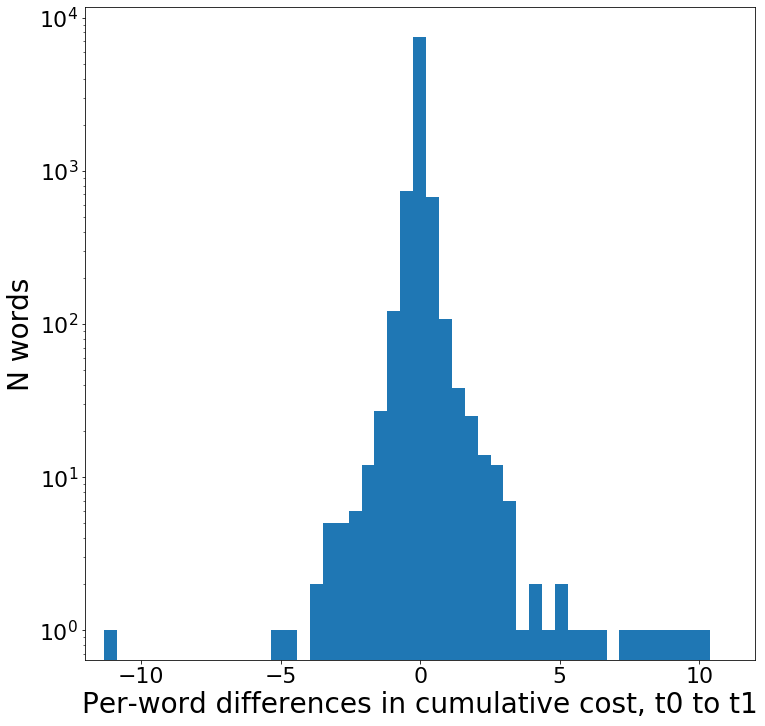

In [124]:
plt.figure(figsize=(12,12))


#sns.distplot(x = list(words_df["cost_abs_change"]),hist=True,norm_hist=False,label="t0 (mean = 0.548)")

plt.hist(list(words_df["cost_abs_change"]),bins=96)

plt.yscale("log")

plt.ylabel("N words",fontsize=28)
plt.xlabel("Per-word differences in cumulative cost, t0 to t1",fontsize=28)

plt.xlim(-12,12)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend(prop={'size': 20})

plt.savefig("/Users/jack/wmdecompose/paper/images/word_level_distances.png",bbox_inches="tight",dpi=500)

plt.show()

In [100]:
words_df.to_csv("../checkpoints/wmd_words_df_cos.csv",index=False)
no_na.to_csv("../checkpoints/wmd_words_df_no_na_cos.csv",index=False)

In [93]:
# look at dynamically ranked clusters

In [94]:
n_clusters = 100
n_words = 10

In [95]:
# conspiracy t0

c1 = output_clusters(wd=wmd_pairs_flow0.wd_source_diff.items(), 
                     cd=wmd_pairs_flow0.cd_source.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

# conspiracy t1

c2 = output_clusters(wd=wmd_pairs_flow1.wd_source_diff.items(), 
                     cd=wmd_pairs_flow1.cd_source.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

# TD t0

c3 = output_clusters(wd=wmd_pairs_flow0.wd_sink_diff.items(), 
                     cd=wmd_pairs_flow0.cd_sink.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

# TD t1

c4 = output_clusters(wd=wmd_pairs_flow1.wd_sink_diff.items(), 
                     cd=wmd_pairs_flow1.cd_sink.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)



In [96]:
c1

,13,76,17,34,89,52,28,90,46,58,...,5,41,54,66,33,15,63,7,22,21
0,thought (1.47),find (3.66),link (2.7),shooting (2.15),strange (1.18),r_conspiracy (2.37),subject (1.16),discuss (1.05),theory (2.97),real (1.43),...,congress (0.44),occult (0.73),september (1.05),darkness (0.15),rd (0.36),dominant (0.13),destruction (0.46),holiday (0.16),symbol (0.62),syrian_refugee (0.26)
1,happen (1.35),information (3.08),page (2.03),police (1.92),appear (1.08),account (1.69),aware (0.64),stuff (0.77),event (2.21),discussion (0.99),...,committee (0.18),symbolism (0.39),date (1.04),wisdom (0.13),mi (0.03),govern (0.09),identity (0.12),anniversary (0.16),star (0.56),woodrow_wilson (0.18)
2,believe (0.96),article (2.31),site (1.51),shooter (1.66),look (0.97),u (1.64),different (0.62),anybody (0.6),major (0.92),topic (0.82),...,chair (0.1),ancient (0.34),august (0.27),gospel (0.12),oregon (0.03),governance (0.06),negro (0.05),christmas (0.15),logo (0.28),campaign_promise (0.09)
3,etc (0.91),read (1.75),search (1.36),shoot (1.41),weird (0.95),comment (1.63),explain (0.57),little (0.5),accident (0.74),question (0.72),...,mccain (0.09),esoteric (0.31),et (0.21),wolf (0.11),vt (0.02),oppression (0.06),male_female (0.05),parade (0.11),worship (0.25),declaration_independence (0.06)
4,maybe (0.67),info (1.63),website (1.05),suspect (1.14),coincidence (0.92),post (1.43),suggest (0.53),crazy (0.29),lead (0.65),actual (0.48),...,congressman (0.09),spiritual (0.24),sept (0.21),prayer (0.09),md (0.01),dominance (0.06),nationality (0.04),crew (0.11),temple (0.2),asylum_seeker (0.04)
5,type (0.65),include (1.45),google (1.03),sandy_hook (1.08),mention (0.87),user (1.13),possible (0.47),pop (0.17),deep (0.52),controversial (0.33),...,schultz (0.07),originate (0.21),december (0.2),wicked (0.09),ak (0.01),domination (0.05),superior (0.03),train (0.04),volume (0.17),ice (0.03)
6,know (0.55),recent (1.04),list (0.88),kill (1.02),disappear (0.8),thread (1.01),course (0.45),vibe (0.15),current (0.51),ask_question (0.27),...,john_mccain (0.07),creator (0.2),dec (0.2),saying (0.08),ct (-0.0),globalization (0.05),inferior (0.02),late_night (0.02),arch (0.15),caravan (0.02)
7,obvious (0.54),regard (0.94),notice (0.8),paris_attack (1.0),suspicious (0.8),delete (0.74),motive (0.45),ok (0.13),occur (0.49),conversation (0.19),...,intelligence_committee (0.06),satanic (0.2),october (0.19),arise (0.07),surround_area (-0.01),tyranny (0.03),prejudice (0.01),christma (0.02),heaven (0.14),census (0.02)
8,figure (0.53),interesting (0.94),text (0.68),murder (1.0),original (0.61),r_worldnews (0.68),possibility (0.4),hi (0.1),predict (0.38),response (0.16),...,congressional (0.04),prophecy (0.2),oct (0.13),holy_spirit (0.06),tx (-0.01),authoritarian (0.03),gender_role (0.01),celebration (0.02),symbolic (0.14),asylum (0.0)
9,completely (0.51),relate (0.93),add (0.66),attack (0.98),odd (0.57),troll (0.38),mean (0.4),m_sure (0.09),unusual (0.36),message (0.15),...,graham (0.04),alchemy (0.18),nov (0.09),curse (0.06),virginia (-0.02),oppressor (0.02),superiority (0.0),recap (0.01),angel (0.13),abraham_lincoln (-0.03)


In [97]:
c2

,13,76,89,17,90,28,82,62,46,2,...,57,22,15,33,7,97,53,54,63,21
0,believe (2.35),find (3.46),look (1.86),link (2.62),talk (1.76),subject (1.29),conspiracy (11.17),epstein (8.97),theory (3.94),q (1.96),...,jfk (0.79),symbol (0.65),dominate (0.24),nm (0.12),anniversary (0.12),rig (0.13),jewish (0.9),date (0.84),identity (0.21),thoma_jefferson (0.05)
1,thought (2.06),information (2.8),weird (1.67),edit (1.86),discuss (1.65),different (1.28),conspiracy_theory (2.81),jeffrey_epstein (2.14),event (1.79),story (1.92),...,bush (0.73),star (0.61),domination (0.09),north_carolina (0.1),easter (0.03),threshold (0.07),jew (0.82),et (0.37),destruction (0.17),george_washinon (0.03)
2,happen (1.93),info (2.14),strange (1.67),notice (1.61),lot (1.15),explain (0.92),new (1.63),pedophile (1.39),major (0.88),book (1.68),...,assassination (0.36),temple (0.35),governance (0.05),west_virginia (0.03),aboard (0.02),rig_election (0.03),zionist (0.54),august (0.3),tran (0.12),woodrow_wilson (0.03)
3,think (1.73),article (1.83),coincidence (1.34),lately (1.0),guy (1.0),motive (0.78),conspiracy_theorist (1.31),ring (1.13),currently (0.69),pizzagate (1.3),...,assassinate (0.23),ghost (0.23),ideological (0.04),mi (0.02),christma (0.01),runner (0.02),zionism (0.31),september (0.24),ethnicity (0.04),lincoln (0.01)
4,know (1.45),interesting (1.6),mention (0.87),search (0.86),stuff (0.96),possible (0.7),begin (0.29),claim (0.93),likely (0.68),cover (1.18),...,jfk_assassination (0.23),stone (0.2),supremacy (0.04),md (-0.0),madman (0.01),rigging (0.01),jews (0.28),december (0.23),creed (0.03),mexico_pay (-0.01)
5,etc (1.27),read (1.51),appear (0.8),page (0.83),crazy (0.62),aware (0.65),beginning (0.13),pedophilia (0.83),lead (0.65),content (0.72),...,kennedy (0.16),worship (0.17),collectivist (0.03),vt (-0.01),navigator (0.0),proportional (-0.0),antisemitic (0.1),april (0.11),diverse (0.03),declaration_independence (-0.01)
6,maybe (1.18),relate (1.47),supposedly (0.74),site (0.81),somebody (0.48),possibly (0.58),ending (0.13),pedo (0.72),deep (0.64),epstein_case (0.49),...,cheney (0.14),hebrew (0.15),dominant (0.02),ne (-0.02),crew (0.0),presidential_race (-0.0),antisemitism (0.07),aug (0.11),superiority (0.02),immigration_policy (-0.02)
7,like (0.98),wonder (1.43),familiar (0.7),instagram (0.61),pop (0.45),possibility (0.57),crack (0.09),dr (0.69),accident (0.57),online (0.49),...,dick_cheney (0.14),flat (0.14),dominance (0.02),ga (-0.02),meme_magic (-0.03),electorate (-0.01),anti_semitic (0.07),jan (0.1),negro (-0.0),abraham_lincoln (-0.02)
8,super (0.98),recently (1.17),suspicious (0.67),facebook (0.6),bit (0.42),far (0.54),ground (0.08),blackmail (0.69),unknown (0.53),chan (0.46),...,george_bush (0.14),vault (0.11),globalization (0.01),virginia (-0.02),shitpost (-0.06),win_nomination (-0.01),anti_semite (0.06),sept (0.1),gender_role (-0.0),syrian_refugee (-0.03)
9,experience (0.91),rabbit_hole (0.98),random (0.66),feature (0.56),idk (0.37),highly (0.41),mount (0.08),sex_trafficking (0.53),mysterious (0.43),epstein_suicide (0.45),...,oswald (0.09),logo (0.11),tyranny (0.01),iowa (-0.02),winning (-0.06),win_presidency (-0.01),pro_israel (0.05),dec (0.07),lesbian (-0.0),legal_immigration (-0.04)


In [ ]:
c3

In [ ]:
c4